In [ ]:
!pip install scikit-learn==0.24

     |████████████████████████████████| 22.3 MB 7.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1


In [ ]:
!pip install mglearn

     |████████████████████████████████| 540 kB 8.5 MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582637 sha256=7a0424f78ee0dc39e77682818bfae8e9f9f19c766106fb467070d4d90721084a
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


Credits: Volodymyr Kuleshov, Cornell Tech

# Support Vector Machines



# Part 1: Classification Margins

In this lecture, we are going to cover Support Vector Machines (SVMs), one the most successful classification algorithms in machine learning.

We start the presentation of SVMs by defining the classification *margin*.

# Review: Components of A Supervised Machine Learning Problem

At a high level, a supervised machine learning problem has the following structure:

$$ \underbrace{\text{Training Dataset}}_\text{Attributes + Features} + \underbrace{\text{Learning Algorithm}}_\text{Model Class + Objective + Optimizer } \to \text{Predictive Model} $$

# Review: Machine Learning Models

A machine learning model is a function
$$ f : \mathcal{X} \to \mathcal{Y} $$
that maps inputs $x \in \mathcal{X}$ to targets $y \in \mathcal{Y}$.

# Review: Binary Classification

Consider a training dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

We distinguish between two types of supervised learning problems depnding on the targets $y^{(i)}$. 

1. __Regression__: The target variable $y \in \mathcal{Y}$ is continuous:  $\mathcal{Y} \subseteq \mathbb{R}$.
2. __Binary Classification__: The target variable $y$ is discrete and takes on one of $K=2$ possible values.

In this lecture, we assume $\mathcal{Y} = \{-1, +1\}$.

# Review: Linear Model Family

In this lecture, we will work with linear models of the form:
\begin{align*}
f_\theta(x) & = \theta_0 + \theta_1 \cdot x_1 + \theta_2 \cdot x_2 + ... + \theta_d \cdot x_d
\end{align*}
where $x \in \mathbb{R}^d$ is a vector of features and $y \in \{-1, 1\}$ is the target. The $\theta_j$ are the *parameters* of the model.

We can represent the model in a vectorized form
\begin{align*}
f_\theta(x) = \theta^\top x + \theta_0.
\end{align*}

# Notation and The Iris Dataset

In this lecture, we are going to again use the Iris flower dataset.

As we just mentioned, we make two additional assumptions:
* We will only consider binary classificaiton problems.
* We will use $\mathcal{Y} =\{-1,1\}$ as the label space.

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris(as_frame=True)
iris_X, iris_y = iris.data, iris.target

# subsample to a third of the data points
iris_X = iris_X.loc[::4]
iris_y = iris_y.loc[::4]

# create a binary classification dataset with labels +/- 1
iris_y2 = iris_y.copy()
iris_y2[iris_y2==2] = 1
iris_y2[iris_y2==0] = -1

# print part of the dataset
pd.concat([iris_X, iris_y2], axis=1).head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,-1
4,5.0,3.6,1.4,0.2,-1
8,4.4,2.9,1.4,0.2,-1
12,4.8,3.0,1.4,0.1,-1
16,5.4,3.9,1.3,0.4,-1


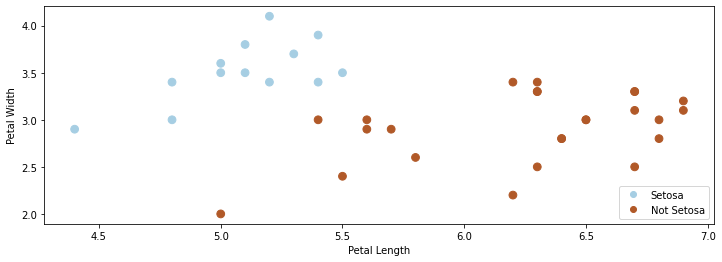

In [ ]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]
import warnings
warnings.filterwarnings("ignore")

# create 2d version of dataset and subsample it
X = iris_X.to_numpy()[:,:2]
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))

# Plot also the training points
p1 = plt.scatter(X[:, 0], X[:, 1], c=iris_y2, s=60, cmap=plt.cm.Paired)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.legend(handles=p1.legend_elements()[0], labels=['Setosa', 'Not Setosa'], loc='lower right')

# Comparing Classification Algorithms

We have seen different types approaches to classification.

When fitting a model, there may be many valid decision boundaries. How do we select one of them?

Consider the following three classification algorithms from `sklearn`. Each of them outputs a different classification boundary.

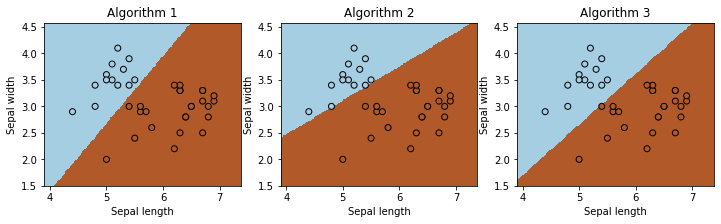

In [ ]:
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier
models = [LogisticRegression(), Perceptron(), RidgeClassifier()]

def fit_and_create_boundary(model):
    model.fit(X, iris_y2)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return Z

plt.figure(figsize=(12,3))
for i, model in enumerate(models):
    plt.subplot('13%d' % (i+1))
    Z = fit_and_create_boundary(model)
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired) 

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=iris_y2, edgecolors='k', cmap=plt.cm.Paired)
    plt.title('Algorithm %d' % (i+1))
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')

plt.show()

# Classification Scores

Most classification algorithms output not just a class label but a score.
* For example, logistic regression returns the class probability
$$ p(y=1|\mid x) = \sigma(\theta^\top x) \in [0,1] $$
If the class probability is $>0.5$, the model outputs class $1$. 

The score is an estimate of confidence; it also represents how far we are from the decision boundary.

# The Max-Margin Principle

Intuitively, we want to select boundaries with high *margin*. 

This means that we are as confident as possible for every point and we are as far as possible from the decision boundary.

Several of the separating boundaries in our previous example had low margin: they came too close to the boundary.

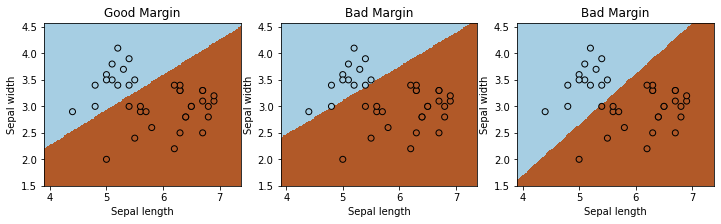

In [ ]:
from sklearn.linear_model import Perceptron, RidgeClassifier
from sklearn.svm import SVC
models = [SVC(kernel='linear', C=10000), Perceptron(), RidgeClassifier()]

def fit_and_create_boundary(model):
    model.fit(X, iris_y2)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    return Z

plt.figure(figsize=(12,3))
for i, model in enumerate(models):
    plt.subplot('13%d' % (i+1))
    Z = fit_and_create_boundary(model)
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired) 

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=iris_y2, edgecolors='k', cmap=plt.cm.Paired)
    if i == 0:
        plt.title('Good Margin')
    else:
        plt.title('Bad Margin')
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')

plt.show()

### Can we formulate a good line to separate classes?

Below, we plot a decision boundary between the two classes (solid line) that has a high margin. The two dashed lines that lie at the margin.

Points that are the margin are highlighted in black. A good decision boundary is as far away as possible from the points at the margin.

(2.25, 4.0)

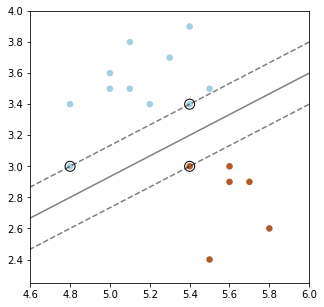

In [ ]:
#https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
from sklearn import svm

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear', C=1000) # we'll explain this algorithm shortly
clf.fit(X, iris_y2)

plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=iris_y2, s=30, cmap=plt.cm.Paired)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# plot decision boundary and margins
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.xlim([4.6, 6])
plt.ylim([2.25, 4])

<img width=40% src="https://wiki.ubc.ca/images/thumb/d/d9/Margin.gif/400px-Margin.gif">

# Geometric Intuitions

The margin $\gamma^{(i)}$ is called geometric because it corresponds to the distance from $x^{(i)}$ to the separating hyperplane $\theta^\top x + \theta_0 = 0$ (dashed line below).

<center><img width=40% src="https://i.imgur.com/KYBfi5L.png"></center>

Thus **higher margin means higher confidence** at each input point.

We can use our formula for $\gamma$ to precisely plot the margins on our earlier plot.

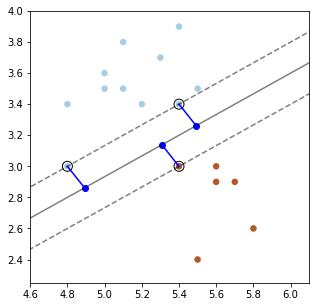

In [ ]:
# plot decision boundary and margins
plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=iris_y2, s=30, cmap=plt.cm.Paired)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.xlim([4.6, 6.1])
plt.ylim([2.25, 4])

# plot margin vectors
theta = clf.coef_[0]
theta0 = clf.intercept_
for idx in clf.support_[:3]:
    x0 = X[idx]
    y0 = iris_y2.iloc[idx]
    margin_x0 = (theta.dot(x0) + theta0)[0] / np.linalg.norm(theta)
    w = theta / np.linalg.norm(theta)
    plt.plot([x0[0], x0[0]-w[0]*margin_x0], [x0[1], x0[1]-w[1]*margin_x0], color='blue')
    plt.scatter([x0[0]-w[0]*margin_x0], [x0[1]-w[1]*margin_x0], color='blue')
plt.show()



---



# Kernelized Support Vector Machines

###Linear Models with Non-Linear Features

Text(0, 0.5, 'Feature 1')

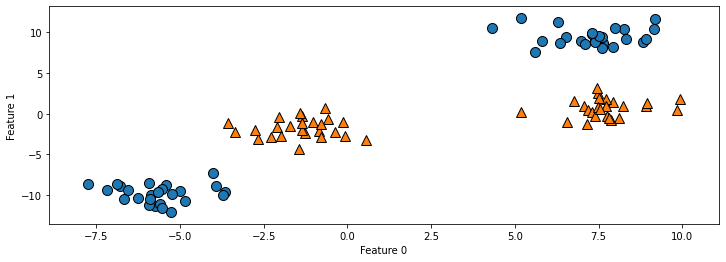

In [ ]:
import mglearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Feature 1')

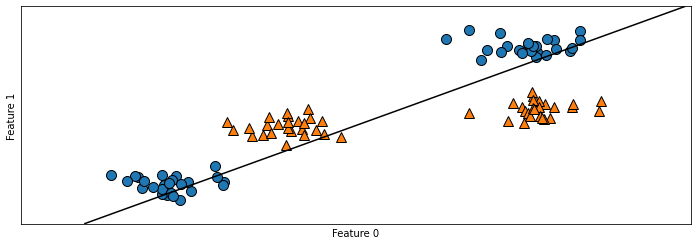

In [ ]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0.5, 0, 'feature1 ** 2')

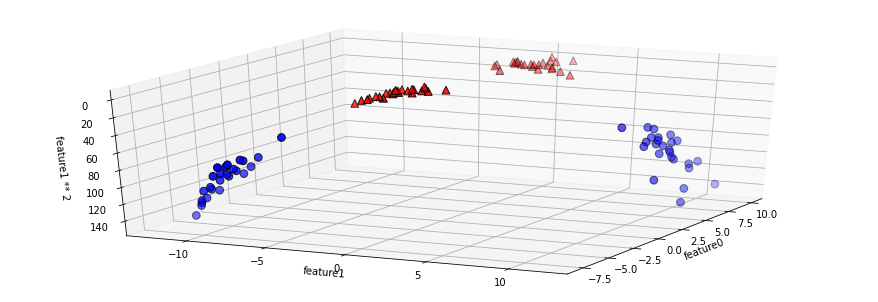

In [ ]:
# add the squared first feature
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()

# visualize in 3D
ax = Axes3D(figure, elev=-152, azim=-26)

# plot first all the points with y==0, then all with y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

### A visualized example (using another dataset)

<img width=40% src="https://miro.medium.com/max/1050/1*XhXJldwvZ9IpGNts41Mefw.gif">

Text(0.5, 0, 'feature1 ** 2')

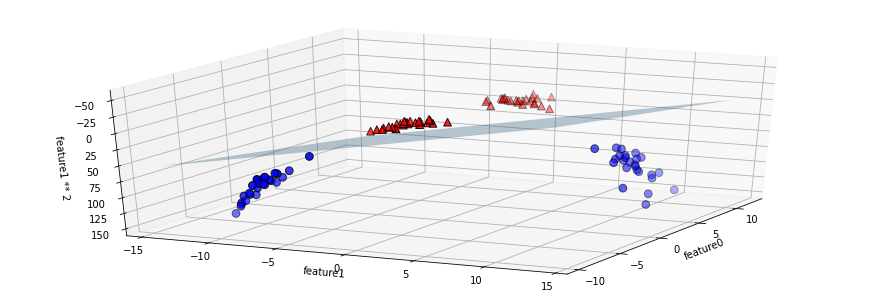

In [ ]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

Text(0, 0.5, 'Feature 1')

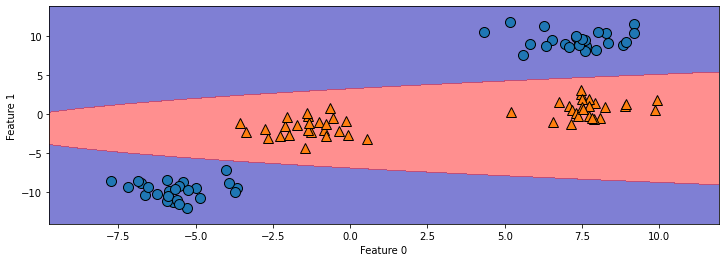

In [ ]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

## The Kernel Trick

The above observations hint at a powerful new idea -- if we can compute dot products of features $\phi(x)$ efficiently, then we will be able to use high-dimensional features easily.

More generally, given features $\phi(x)$, suppose that we have a function $K : \mathcal{X} \times \mathcal{X} \to [0, \infty]$ that outputs dot products between vectors in $\mathcal{X}$

$$ K(x, z) = \phi(x)^\top \phi(z). $$


It turns our that we can do this for many ML algorithms -- we will call $K$ the *kernel* function.

The ***Kernel Trick*** means that we can use complex non-linear features within  these algorithms with little additional computational cost.

### Different Kernel Tricks

<img width=60% src="https://miro.medium.com/max/1500/1*V_jH1lc4XOUxxVCPn-13cQ.png">

### Radial Basis Function Kernel

The Radial basis function kernel, also called the RBF kernel, or Gaussian kernel, is a kernel that is in the form of a radial basis function (more specifically, a Gaussian function). The RBF kernel is defined as

$$K(x,z) = \exp \left(-\frac{||x - z||^2}{2\sigma^2}\right),$$
where $\sigma$ is a hyper-parameter. It's easiest to understand this kernel by viewing it as a similarity measure.


Text(0, 0.5, 'Feature 1')

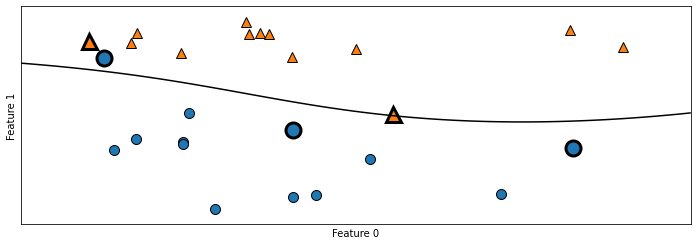

In [ ]:
from sklearn.svm import SVC

X, y = mglearn.tools.make_handcrafted_dataset()                                                                  
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)

# plot support vectors
sv = svm.support_vectors_

# class labels of support vectors are given by the sign of the dual coefficients
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

### Tuning SVM parameters

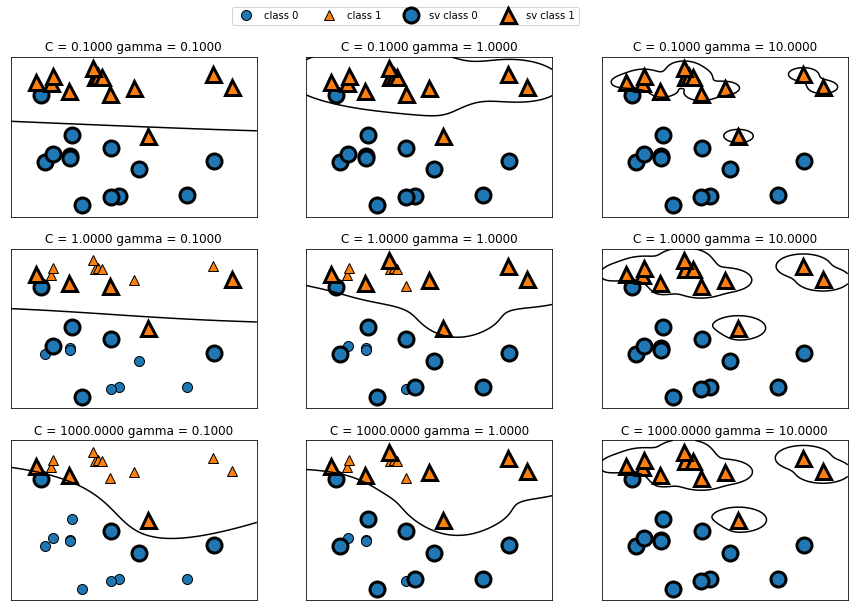

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)
        
axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"],
                  ncol=4, loc=(.9, 1.2))

## Notes


*   Intuitively, the `gamma` $\gamma$ parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

<img src="https://miro.medium.com/max/1500/1*B8e0TE2rTx8gdOH1FA1rXg.png">

*   The `C` parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of `C`, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words `C` behaves as a regularization parameter in the SVM.

<img width=60% src="https://learnopencv.com/wp-content/uploads/2018/07/svm-parameter-c-example.png">

### Cause and Effect

*   When `gamma` is very small, the model is too constrained and cannot capture the complexity or “shape” of the data. The region of influence of any selected support vector would include the whole training set. The resulting model will behave similarly to a linear model with a set of hyperplanes that separate the centers of high density of any pair of two classes.
*   On the other hand, lower `C` values generally lead to more support vectors, which may increase prediction time. Therefore, lowering the value of C involves a trade-off between fitting time and prediction time.



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.90
Accuracy on test set: 0.94


## Handling Multiclass Problems
Binary classification algorithms can be adapted for multi-class classification tasks using a variety of strategies.

### One vs. Rest (OvR) Approach
For the **one vs. rest method**, a binary model is created for each of the multiple output classes. Each of these binary models for the individual classes is assessed against its complement (all other classes in the model) as though it were a binary classification issue. Prediction is then performed by running these binary classifiers, and choosing the prediction with the highest confidence score.


<img justify="center" src="https://www.machinecurve.com/wp-content/uploads/2020/10/whatisclassification5.png">


For this example, training an **one-vs-rest classifier** for our model actually involves creating three binary classifiers under the hood:

*   OvR binary classifier 1: yellow vs {blue, red}
*   OvR binary classifier 2: blue vs {yellow, red}
*   OvR binary classifier 3: red vs {blue, yellow}

The *argmax* of these scores (class index with the largest score) is then used to predict a class.



<img src="https://miro.medium.com/max/1280/1*yl94cZSxYP7mE6rllD_4og.jpeg">

### One vs. One (OvO) Approach
For the **one vs. one method**, consists in fitting one classifier per class pair. At prediction time, the class which received the most votes is selected. Since it requires to fit n_classes * (n_classes - 1) / 2 classifiers, this method is usually slower than one-vs-the-rest.

For example, consider a multi-class classification problem with four classes: ‘red,’ ‘blue,’ and ‘green,’ ‘yellow.’ This could be divided into six binary classification datasets as follows:

*    Binary Classification Problem 1: red vs. blue
*    Binary Classification Problem 2: red vs. green
*    Binary Classification Problem 3: red vs. yellow
*    Binary Classification Problem 4: blue vs. green
*    Binary Classification Problem 5: blue vs. yellow
*    Binary Classification Problem 6: green vs. yellow